# Coding CNNs from Scratch with Pytorch

In this assignment you will code a famous CNN architecture AlexNet (https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) to classify images from the CIFAR10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 10 classes of natural images such as vehicles or animals. AlexNet is a landmark architecture because it was one of the first extremely deep CNNs trained on GPUs, and achieved state-of-the-art performance in the ImageNet challenge in 2012.


A lot of code will already be written to familiarize yourself with PyTorch, but you will have to fill in parts that will apply your knowledge of CNNs. Additionally, there are some numbered questions that you must answer either in a separate document, or in this notebook. Some questions may require you to do a little research. To type in the notebook, you can insert a text cell.

Let's start by installing PyTorch and the torchvision package below. Due to the size of the network, you will have to run on a GPU. So, click on the Runtime dropdown, then Change Runtime Type, then GPU for the hardware accelerator.

In [1]:
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# device = torch.device('cuda')

# print(device)

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [3]:
!nvidia-smi

Thu May 16 17:50:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.65                 Driver Version: 546.65       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   37C    P5              28W / 200W |    971MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 1. In the following cell, we are employing something called "data augmentation" with random horizontal and vertical flips. So when training data is fed into the network, it is ranadomly transformed. What are advantages of this?

### 2. We normalize with the line transforms.Normalize((0.5,), (0.5,)). What are the benefits of normalizing data?




1. Data augmentation, such as random horizontal and vertical flips, increases the diversity of the training dataset without collecting more data. This technique helps the model generalize better to new, unseen data by preventing overfitting. By presenting various transformations of the images, the model learns to recognize objects in different orientations, which makes it more robust. Moreover, this approach helps the model become invariant to these transformations, enhancing its ability to perform well in real-world scenarios where objects may appear in different orientations.

2. Normalizing data with transforms.Normalize((0.5,), (0.5,)) scales the input data to have a mean of 0 and a standard deviation of 1. This standardization is crucial for several reasons. First, it speeds up the convergence of gradient descent during training by ensuring that all input features are on a similar scale. Second, it helps avoid issues related to numerical instability and exploding/vanishing gradients, making the training process more stable. Finally, normalization ensures that the network learns weights more effectively, leading to better performance and faster training.

In [4]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from math import ceil

BATCH_SIZE = 100


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

torch.manual_seed(43)
val_size = 10000
train_size = len(trainset) - val_size


train_ds, val_ds = random_split(trainset, [train_size, val_size])
print(len(train_ds), len(val_ds))


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_steps =  ceil(len(train_ds) / BATCH_SIZE)
num_steps

Files already downloaded and verified
Files already downloaded and verified
40000 10000


400

In [5]:
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testset, BATCH_SIZE)

You can insert an integer  into the code trainset[#insert integer] to visualize images from the training set. Some of the images might look weird because they have been randomly flipped according to our data augmentation scheme.

Label (numeric): 6
Label (textual): frog


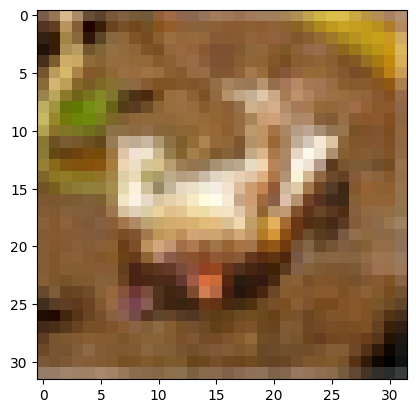

In [6]:
img, label = trainset[0]
plt.imshow((img.permute((1, 2, 0))+1)/2)
print('Label (numeric):', label)
print('Label (textual):', classes[label])

Now comes the fun part. You will have to put in the correct parameters into different torch.nn functions in order to convolve and downsample the image into the correct dimensionality for classification. Think of it as a puzzle. You will insert the parameters where there is a comment #TODO.

In [7]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192,
                      384,
                      kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        # Calculate the number of features after the convolutional layers
        self._initialize_linear_input_features()

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def _initialize_linear_input_features(self):
        with torch.no_grad():
            dummy_input = torch.zeros(
                1, 3, 32, 32
            ) # specify the input size of our network
            features = self.features(dummy_input)
            self.num_features = features.view(1, -1).size(1)

    def forward(self, x):
        x = self.features(x)
        # we must flatten our feature maps before feeding into fully connected layers
        x = x.contiguous().view(x.size(0), -1)
        x = self.classifier(x)
        return x

Below we are initializing our model with a weight scheme.

In [8]:
net = Discriminator()

def weights_init(m):

    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)


# Initialize Models
net = net.to(device)

net.apply(weights_init)



Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0

# 3. Notice above in our network architecture, we have what are called "Dropout" layers. What is the point of these?

3. Dropout layers are a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly "drops" a fraction of neurons, setting their output to zero. This forces the network to learn more robust features, as it can't rely on any single neuron. By doing this, the network generalizes better to unseen data, improving its performance on the test set. In essence, dropout helps the network avoid becoming too tailored to the training data and instead learn patterns that are more widely applicable.

Defining our cost/loss function, which is cross-entropy loss. We also define our optimizer with hyperparameters: learning rate and betas.

In [9]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=0.0002,
    betas = (0.5, 0.999)
)


Below we actually train our network. Run for just 10 epochs. It takes some time. Wherever there is the comment #TODO, you must insert code.

In [10]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)     #pass input data into network to get outputs
        loss = criterion(outputs, labels)
        loss.backward()  #calculate gradients
        optimizer.step() #take gradient descent step

        running_loss += loss.item()

    print("E:{}, Train Loss:{}".format(
                epoch+1,
                running_loss / num_steps
            )
        )

    # validation
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            # TODO: load images and labels from validation loader
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)  # run forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)       #calculate validation loss
            val_loss += loss.item()
    val_loss /=num_steps
    print('Accuracy of 10000 val images: {}'.format( correct / total))
    print('Val Loss: {}'.format( val_loss))

print('Finished Training')

E:1, Train Loss:1.9267987021803856
Accuracy of 10000 val images: 0.3369
Val Loss: 0.43540037512779234
E:2, Train Loss:1.577186998128891
Accuracy of 10000 val images: 0.4601
Val Loss: 0.3608863279223442
E:3, Train Loss:1.402827124297619
Accuracy of 10000 val images: 0.4822
Val Loss: 0.3492458724975586
E:4, Train Loss:1.2843626663088799
Accuracy of 10000 val images: 0.5251
Val Loss: 0.3230030071735382
E:5, Train Loss:1.184310462921858
Accuracy of 10000 val images: 0.5722
Val Loss: 0.2963975059986115
E:6, Train Loss:1.1096938508749008
Accuracy of 10000 val images: 0.591
Val Loss: 0.28300827845931054
E:7, Train Loss:1.0468915204703808
Accuracy of 10000 val images: 0.597
Val Loss: 0.28580799102783205
E:8, Train Loss:0.9906741769611835
Accuracy of 10000 val images: 0.5958
Val Loss: 0.2820750530064106
E:9, Train Loss:0.93946278616786
Accuracy of 10000 val images: 0.6284
Val Loss: 0.2618029835820198
E:10, Train Loss:0.8902475713193416
Accuracy of 10000 val images: 0.6444
Val Loss: 0.2531955054

## 4. If we train for more epochs, our accuracy/performance will increase. What happens if we train for too long though? What method can be employed to mitigate this?

## 5. Try increasing learning rate and look at the metrics for training and validation data? What do you notice? Why do think this is happening?



4. Training for too long can lead to overfitting, where the model learns the noise and details in the training data to the extent that it performs poorly on new, unseen data. To mitigate this, we can use techniques like early stopping, which monitors the validation performance and stops training when performance no longer improves. Regularization methods like dropout and weight decay can also help prevent overfitting by adding constraints that keep the model from becoming too complex.

5. Increasing the learning rate often leads to faster convergence initially, but it can also cause the training process to become unstable. You might notice that the training loss fluctuates or increases, and the validation performance might degrade. This happens because a high learning rate can cause the model to overshoot the optimal weights, making it difficult for the gradient descent algorithm to settle into a minimum. Reducing the learning rate can help achieve more stable and reliable convergence.

We can see the performance on the testing set now.

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of 10000 test images: {}'.format( correct / total))

Accuracy of 10000 test images: 0.6971
